In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Resizing, Rescaling, RandomFlip
from keras.utils import image_dataset_from_directory
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.applications import EfficientNetV2L
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from keras import callbacks
f'Tensorflow version: {tf.__version__}'

'Tensorflow version: 2.12.0'

In [15]:
imagesize = 256
batchsize = 32
rand_seed = 10

train_ds = image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI',
    image_size = (imagesize, imagesize),
    batch_size = batchsize,
    validation_split = 0.2,
    subset = 'training',
    labels = 'inferred',
    shuffle = True,
    seed = rand_seed
)

valid_ds = image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI',
    image_size = (imagesize, imagesize),
    batch_size = batchsize,
    validation_split = 0.2,
    subset = 'validation',
    labels = 'inferred',
    shuffle = True,
    seed = rand_seed
)

Found 35202 files belonging to 4 classes.
Using 28162 files for training.
Found 35202 files belonging to 4 classes.
Using 7040 files for validation.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
base_model = EfficientNetV2L(include_top=False,
    weights='imagenet',
    input_shape=(imagesize, imagesize, 3))
base_model.trainable = False

In [18]:
model = Sequential([
    RandomFlip("horizontal"),
    base_model,
    Flatten(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

In [19]:
model.build(input_shape = (None, imagesize, imagesize, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 8, 8, 1280)       117746848 
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              83887104  
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 512)              

In [20]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)

In [21]:
lr_init = 0.0008

In [22]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr + lr_init
    elif epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [23]:
lr_callback = callbacks.LearningRateScheduler(lr_scheduler, verbose = 1)

In [24]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [25]:
model.compile(optimizer=Adam(lr_init),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=valid_ds,
                   callbacks=[early_stopping,lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0015999999797903.
Epoch 1/100


2023-10-08 02:17:29.666282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


881/881 [==============================] - 356s 374ms/step - loss: 0.9572 - accuracy: 0.5614 - val_loss: 0.7290 - val_accuracy: 0.6446 - lr: 0.0016

Epoch 2: LearningRateScheduler setting learning rate to 0.0023999999595806.
Epoch 2/100
881/881 [==============================] - 322s 365ms/step - loss: 0.7546 - accuracy: 0.6484 - val_loss: 0.6940 - val_accuracy: 0.6753 - lr: 0.0024

Epoch 3: LearningRateScheduler setting learning rate to 0.0031999998811632394.
Epoch 3/100
881/881 [==============================] - 322s 365ms/step - loss: 0.7020 - accuracy: 0.6832 - val_loss: 0.6531 - val_accuracy: 0.7095 - lr: 0.0032

Epoch 4: LearningRateScheduler setting learning rate to 0.003999999919161201.
Epoch 4/100
881/881 [==============================] - 319s 362ms/step - loss: 0.6670 - accuracy: 0.7036 - val_loss: 0.7402 - val_accuracy: 0.6780 - lr: 0.0040

Epoch 5: LearningRateScheduler setting learning rate to 0.004799999724328518.
Epoch 5/100
881/881 [==============================] - 32

In [27]:
model.save('alzheimer_detection.h5')

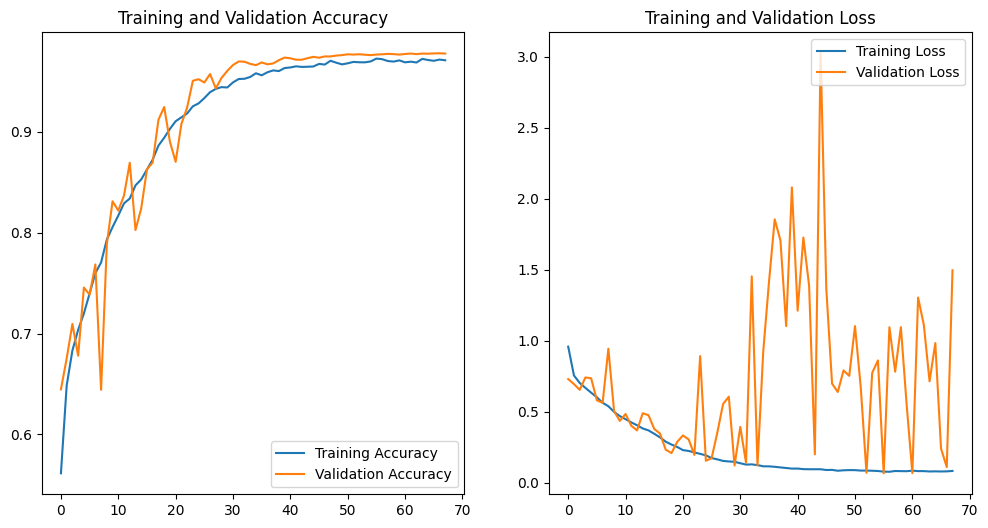

In [28]:
plot_history(history)

In [29]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/alzheimer_detection.h5 (deflated 17%)


In [30]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip